In [30]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform


rs = 13

In [31]:
data = pd.read_csv('data.csv')
data.head()

,Country,Year,Status,Population,Hepatitis B,Measles,Polio,Diphtheria,HIV/AIDS,infant deaths,under-five deaths,Total expenditure,GDP,BMI,thinness 1-19 years,Alcohol,Schooling,Life expectancy
0,Afghanistan,2015,Developing,33736494.0,65.0,1154,6.0,65.0,0.1,62,83,8.16,584.259210,19.1,17.2,0.01,10.1,65.0
1,Afghanistan,2014,Developing,327582.0,62.0,492,58.0,62.0,0.1,64,86,8.18,612.696514,18.6,17.5,0.01,10.0,59.9
2,Afghanistan,2013,Developing,31731688.0,64.0,430,62.0,64.0,0.1,66,89,8.13,631.744976,18.1,17.7,0.01,9.9,59.9
3,Afghanistan,2012,Developing,3696958.0,67.0,2787,67.0,67.0,0.1,69,93,8.52,669.959000,17.6,17.9,0.01,9.8,59.5
4,Afghanistan,2011,Developing,2978599.0,68.0,3013,68.0,68.0,0.1,71,97,7.87,63.537231,17.2,18.2,0.01,9.5,59.2


In [32]:
class Preprocessing(): 
    def __init__(self):
        self.col_means = {} # based on each country
        self.col_medians = {}
    
    # Computing and remembering the mean (w.r.t. each country) and median value of each column
    def fit(self, data):
        cols_with_na = data.isna().sum()[data.isna().sum()>0].index.tolist()
        for col in cols_with_na:
            self.col_means[col] = data.groupby('Country')[col].transform('mean')
            self.col_medians[col] = data[col].median()

    # Applying preprocessing on data
    def transform(self, data):
        
        # Finding those columns which contain NaN values
        cols_with_na = data.isna().sum()[data.isna().sum()>0].index.tolist()
        # Fill NaN values of each column with its mean value (w.r.t. country)
        for col in cols_with_na:
            mean_value = self.col_means[col]
            data.loc[:, col] = data.loc[:, col].fillna(mean_value)

        # Finding those columns which still contain NaN values
        cols_with_na = data.isna().sum()[data.isna().sum()>0].index.tolist()
        # Fill NaN values of each column with median value
        for col in cols_with_na:
            median_value = self.col_medians[col]
            data.loc[:, col] = data.loc[:, col].fillna(median_value)
        
        # Encoding the Status column
        data['Status'] = data['Status'].map({'Developing' : 0, 'Developed' : 1,})
        
        return data

    # Applying preprocessing on training data
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [33]:
train, test = train_test_split(data, test_size=0.3, random_state=rs)

In [34]:
preprocesser = Preprocessing()

train = preprocesser.fit_transform(train)
test = preprocesser.transform(test)

In [35]:
test_data, val_data = train_test_split(test, test_size=0.5, random_state=rs)

In [36]:
train = train.drop('Country', axis=1)
val_data = val_data.drop('Country', axis=1)
test_data = test_data.drop('Country', axis=1)

<Axes: >

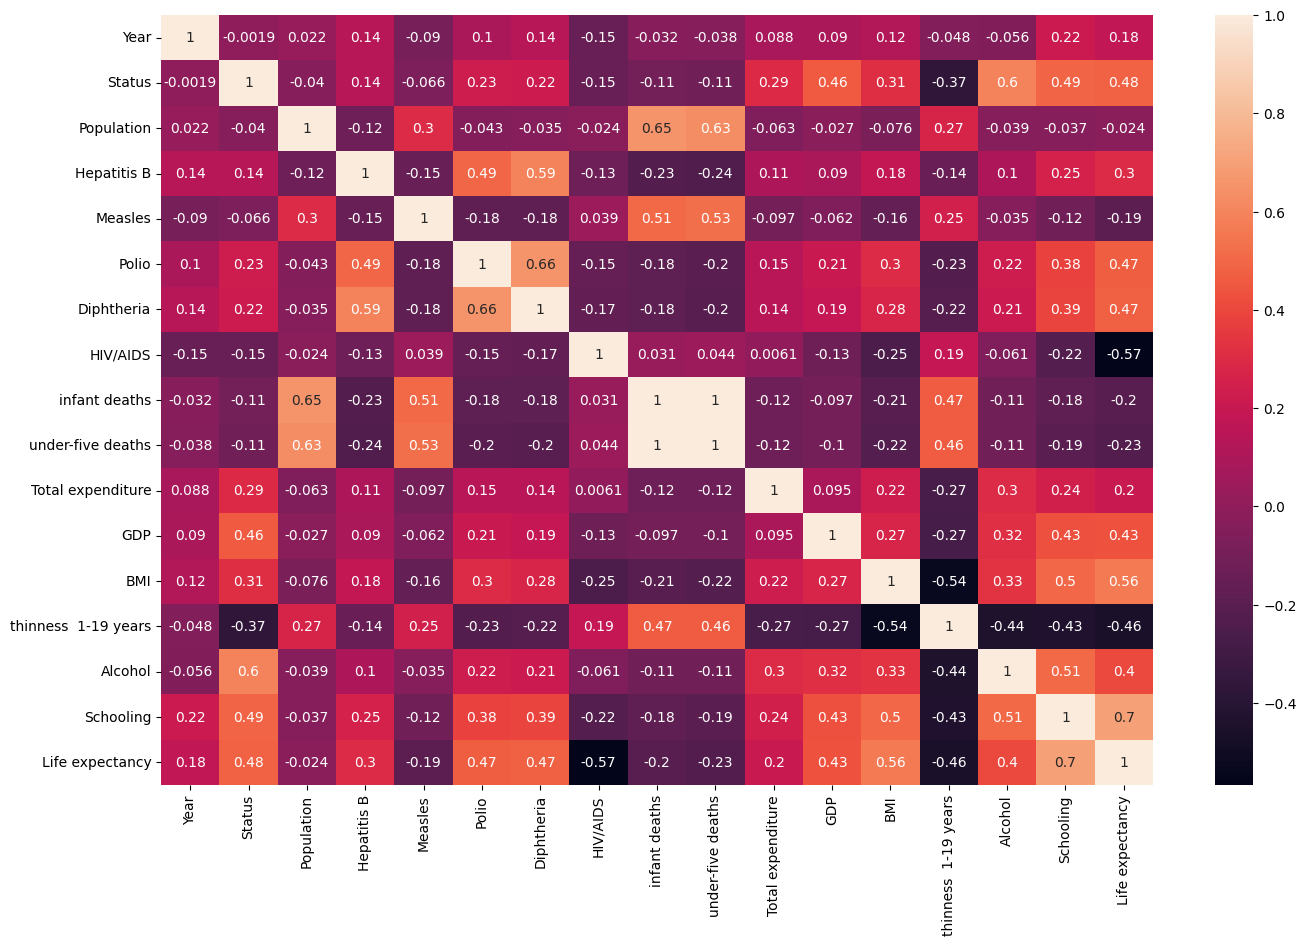

In [37]:
plt.figure(figsize=(16, 10))  
sns.heatmap(train.corr(), annot=True)

In [38]:
train.describe()

,Year,Status,Population,Hepatitis B,Measles,Polio,Diphtheria,HIV/AIDS,infant deaths,under-five deaths,Total expenditure,GDP,BMI,thinness 1-19 years,Alcohol,Schooling,Life expectancy
count,1993.000000,1993.000000,1.993000e+03,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000
mean,2007.389363,0.176116,1.097423e+07,79.214981,2123.958354,83.062664,82.474765,1.801204,27.808329,38.849473,5.899777,6675.408913,38.608630,4.845810,4.619860,12.066232,69.310437
std,4.614227,0.381015,6.339080e+07,24.860507,10648.352307,22.566372,23.450836,5.241105,115.167908,157.792584,2.424740,13288.628806,19.689574,4.402748,3.986625,3.220876,9.614872
min,2000.000000,0.000000,3.400000e+01,1.000000,0.000000,3.000000,3.000000,0.100000,0.000000,0.000000,0.650000,3.685949,1.000000,0.100000,0.010000,0.000000,36.300000
25%,2003.000000,0.000000,4.494160e+05,73.000000,0.000000,78.000000,78.000000,0.100000,0.000000,0.000000,4.270000,592.183522,19.800000,1.600000,1.020000,10.400000,63.500000
50%,2007.000000,0.000000,1.445958e+06,91.000000,15.000000,93.000000,93.000000,0.100000,3.000000,4.000000,5.720000,1887.823661,43.900000,3.400000,3.800000,12.400000,72.200000
75%,2011.000000,0.000000,4.488263e+06,96.000000,336.000000,97.000000,97.000000,0.700000,21.000000,26.000000,7.390000,4991.982890,55.900000,7.100000,7.630000,14.000000,75.700000
max,2015.000000,1.000000,1.293859e+09,99.000000,212183.000000,99.000000,99.000000,50.600000,1800.000000,2500.000000,17.600000,115761.577000,77.100000,27.700000,17.870000,20.700000,89.000000


In [39]:
x_train, y_train = train.drop('Life expectancy', axis=1), train['Life expectancy']
x_val, y_val = val_data.drop('Life expectancy', axis=1), val_data['Life expectancy']
x_test, y_test = test_data.drop('Life expectancy', axis=1), test_data['Life expectancy']

In [40]:
std_scaler = StandardScaler()

x_train = std_scaler.fit_transform(x_train)
x_val = std_scaler.transform(x_val)
x_test = std_scaler.transform(x_test)

<h1>Polynomial Regression</h1>

In [41]:
val_r2_scores = []
train_r2_scores = []

for k in range(1,3):
    poly_transformer = PolynomialFeatures(degree=k)
    poly_transformer.fit(x_train)
    poly_features = poly_transformer.transform(x_train)

    model = LinearRegression()
    model.fit(poly_features, y_train)

    valid_poly_features = poly_transformer.transform(x_val)
    y_pred = model.predict(valid_poly_features)
    y_pred_t = model.predict(poly_features)
    val_r2_scores.append(r2_score(y_val, y_pred))
    train_r2_scores.append(r2_score(y_train, y_pred_t))
    print(f'Validation r2_score for degree = {k} val:', r2_score(y_val, y_pred)) 
    print(f'Validation r2_score for degree = {k} train:', r2_score(y_train, y_pred_t)) 

Validation r2_score for degree = 1 val: 0.792753602939736
Validation r2_score for degree = 1 train: 0.7716458896159422
Validation r2_score for degree = 2 val: 0.8619145993237313
Validation r2_score for degree = 2 train: 0.8886480161258237


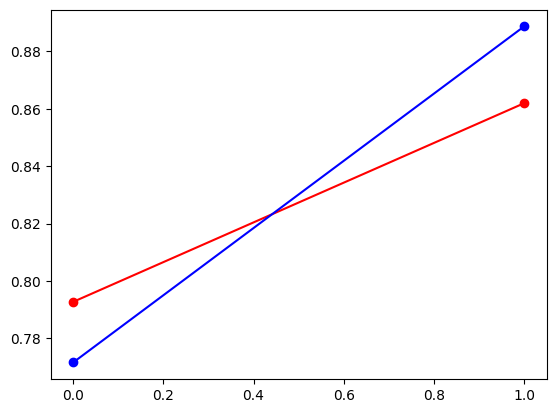

In [42]:
plt.plot(val_r2_scores, marker='o', linestyle='-', color='red', label='Data')
plt.plot(train_r2_scores, marker='o', linestyle='-', color='b', label='Data')

In [43]:
poly_transformer = PolynomialFeatures(degree=2)
poly_transformer.fit(x_train)
poly_features = poly_transformer.transform(x_train)

model = LinearRegression()
model.fit(poly_features, y_train)

LinearRegression()

In [44]:
test_poly_features = poly_transformer.transform(x_test)
y_pred = model.predict(test_poly_features)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print('Validation r2_score for degree:', r2_score(y_test, y_pred)) 

Mean Squared Error (MSE): 15.86842064589634
Validation r2_score for degree: 0.8289735851588297


<h1>ElasticNet </h1>

In [45]:
model = ElasticNet(random_state=rs)

param_distributions = {
    'alpha': uniform(0.1, 5.0),  
    'l1_ratio': uniform(0.1, 0.9)  
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=1000,  
    scoring='r2',
    cv=5,
    verbose=1,
    random_state=rs,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Parameters:", best_params)

y_pred = best_model.predict(x_val)
r2 = r2_score(y_val, y_pred)
print("R-squared (R2):", r2)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best Parameters: {'alpha': np.float64(0.11295883934569864), 'l1_ratio': np.float64(0.7534139269980502)}
R-squared (R2): 0.7832754619766626


In [46]:
model = ElasticNet(random_state=rs, alpha=0.11295883934569864, l1_ratio=0.7534139269980502)

model.fit(x_train, y_train)

ElasticNet(alpha=0.11295883934569864, l1_ratio=0.7534139269980502,
           random_state=13)

In [47]:
y_pred = model.predict(x_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print('Validation r2_score for degree:', r2_score(y_test, y_pred)) 

Mean Squared Error (MSE): 22.163540514574503
Validation r2_score for degree: 0.761126141096155


<h1>K-Nearest Neighbors (KNN)</h1>

The best value of k is: 4 with MSE = 8.779


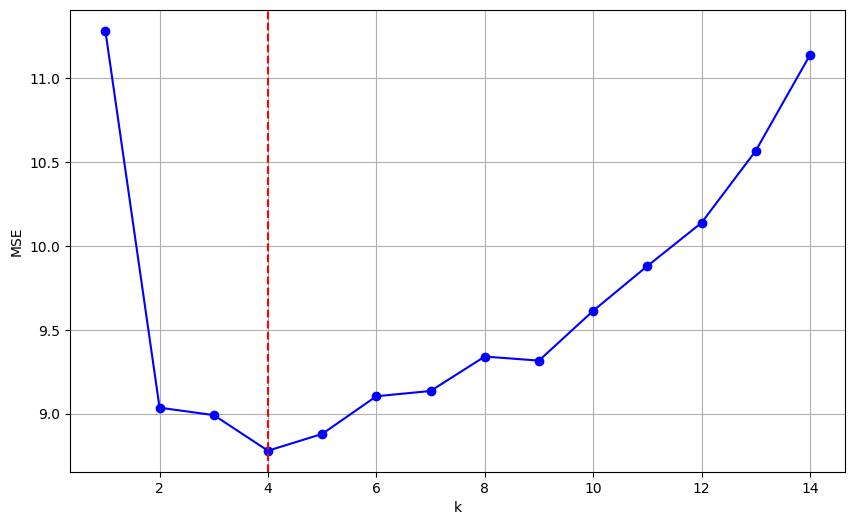

In [48]:
k_values = range(1, 15)   
mse_values = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_val)
    mse = mean_squared_error(y_val, y_pred)
    mse_values.append(mse)

best_k = k_values[np.argmin(mse_values)]
print(f"The best value of k is: {best_k} with MSE = {min(mse_values):.3f}")

# Plot MSE vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_values, mse_values, marker='o', color='blue', label='Mean Squared Error (MSE)')
plt.axvline(best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
plt.xlabel('k')
plt.ylabel('MSE')
plt.grid()
plt.show()

In [49]:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=4)

In [50]:
y_pred = knn.predict(x_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print('Validation r2_score for degree:', r2_score(y_test, y_pred)) 

Mean Squared Error (MSE): 12.283751463700236
Validation r2_score for degree: 0.8676083763773984


<h1>Decision Tree</h1>

In [51]:
model = DecisionTreeRegressor(random_state=rs)
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [52]:
model = DecisionTreeRegressor(random_state=rs, max_depth=15, min_samples_leaf=4, min_samples_split=2)
model.fit(x_train, y_train)

y_pred = model.predict(x_val)
print("Mean Squared Error:", r2_score(y_val, y_pred))

Mean Squared Error: 0.8809293680030614


In [53]:
y_pred = model.predict(x_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print('Validation r2_score for degree:', r2_score(y_test, y_pred)) 

Mean Squared Error (MSE): 10.98749034377521
Validation r2_score for degree: 0.8815791991193648
